In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *

### Estimate propagation direction of a single incoming wave

author: Sebastian Noe, snoe@geophysik.uni-muenchen.de

$
\ddot u_x = -A\omega^2n_x\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\ddot u_y = -A\omega^2n_y\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\ddot u_z = -A\omega^2n_z\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\dot\Omega_x = -\frac{A\omega^2}{2v}(\nu_yn_z-\nu_zn_y)\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\dot\Omega_y = -\frac{A\omega^2}{2v}(\nu_zn_x-\nu_xn_z)\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\dot\Omega_z = -\frac{A\omega^2}{2v}(\nu_xn_y-\nu_yn_x)\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

$
\dot\epsilon_{zz} = -\frac{A\omega^2}{v}\nu_zn_z\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$




#### Using 7C seismometer

Translational measurements are used to determine the polarization vector $n$.
Ratios of rotational components and the horizontal deformation are formed to extract the propagation direction. These ratios have the advantage of eliminating the unknown phase-velocity $v$.

$
\frac{\dot\Omega_y}{\dot\epsilon_{zz}} = \frac{1}{2}\frac{\nu_zn_x-\nu_xn_z}{\nu_zn_z} = \frac{1}{2}(\frac{n_x}{n_z}-\frac{\nu_x}{\nu_z})
$

$
\frac{\dot\Omega_x}{\dot\epsilon_{zz}} = \frac{1}{2}\frac{\nu_yn_z-\nu_zn_y}{\nu_zn_z} = \frac{1}{2}(\frac{\nu_y}{\nu_z}-\frac{n_y}{n_z})
$

Assuming (before normalization) $\nu_z=1$, we see

$
\nu = \begin{pmatrix}- \frac{2\dot\Omega_y}{\dot\epsilon_{zz}}+ \frac{n_x}{n_z}\\ \frac{2\dot\Omega_x}{\dot\epsilon_{zz}} + \frac{n_y}{n_z}  \\ 1 \end{pmatrix}
$

This works for all wavetypes (qP, qS1, qS2) of all symmetries. Some directions may not be resolvable, including purely horizontal propagating waves or purely horizontal polarized waves. 

The latter is the case for SH-waves in VTI-media. 
The problem is that the polarization is purely horizontal, i.e. the vertical strain is zero. One could try to form ratios between rotational components: 

$\dot\Omega_y / \dot\Omega_x = n_x/n_y$ 

$\dot\Omega_z / \dot\Omega_y = \frac{\nu_x}{\nu_z}\frac{n_y}{n_x}-\frac{\nu_y}{\nu_z}$

$\dot\Omega_z / \dot\Omega_x = \frac{\nu_y}{\nu_x}\frac{n_x}{n_y}-\frac{\nu_x}{\nu_z}$

The first equation doesn't contain any new information and the other two can be transformed to (assuming $\nu_z=1$, before normalization):

$
\begin{pmatrix}\dot\Omega_z / \dot\Omega_y \\ \dot\Omega_z / \dot\Omega_x \end{pmatrix} = \begin{pmatrix} \frac{n_y}{n_x} & -1 \\ -1 & \frac{n_x}{n_y} \end{pmatrix} \begin{pmatrix} \nu_x\\\nu_y \end{pmatrix}
$

The matrix's determinant is 0. Hence, the system cannot be uniquely solved and the propagation direction cannot be determined. 

With the same reasoning, one can show that one needs the seventh-component (vertical strain) in order to determine propagation direction for single wavefronts.

Having the full translational and rotational measurements, one can always find a rotation for the seismometer such that $n_z=0$. The resulting rotational ratios follow above's derivation, leading to the same singular matrix. Not forming ratios is also not an option as the cross-product operator is not invertible.

In [2]:
def get_seis_one_wavetype(mode,v,vel,nu,f):
    
    l1 = np.argmax(vel)
    l3 = np.argmin(vel)
    for i in range(0,3):
        if l1!=i and l3!=i:
            l2 = i
    if mode=='qP':
        vel_0 = vel[l1]
        v_0 = v[:,l1]
    elif mode=='qS1':
        vel_0 = vel[l2]
        v_0 = v[:,l2]
    elif mode=='qS2':
        vel_0 = vel[l3]
        v_0 = v[:,l3]
    
    xr = max(vel)
    tmax = xr / min(vel) * 1.3
    nt = 30000
    t = np.linspace(0,tmax,nt)
    seis = np.zeros((7,nt))   
    A = 1
    omega = 2*np.pi*f
    vel = vel_0
    v = v_0
    
    seis[0,:] = - v[0]*A*omega**2*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2) 
    seis[1,:] = - v[1]*A*omega**2*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2)
    seis[2,:] = - v[2]*A*omega**2*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2)
     
    
    seis[3,:] =- np.cross(nu,v)[0]*A*omega**2/(2*vel)*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2)
    seis[4,:] =- np.cross(nu,v)[1]*A*omega**2/(2*vel)*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2)
    seis[5,:] =- np.cross(nu,v)[2]*A*omega**2/(2*vel)*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2)
    
    seis[6,:] = - A * omega**2/vel*v[2]*nu[2]*(t-xr/vel)*np.exp(-(f**2)*(t-xr/vel)**2) 
    
    return seis, t

In [3]:
def plot_7C(seis,t):
    a1 = abs(seis[0:3][:].max())
    plt.figure(figsize=(8,4))
    plt.title('Translation')
    
    plt.plot(t,seis[0,:],label='x')
    plt.plot(t,seis[1,:]-a1,label='y')
    plt.plot(t,seis[2,:]-2*a1,label='z')
    plt.legend()
    plt.yticks([])
    plt.show()
    a2 = seis[3:6][:].max()
    plt.figure(figsize=(8,4))
    plt.title('Rotation')
    plt.plot(t,seis[3,:],label='rot_x')
    plt.plot(t,seis[4,:]-a2,label='rot_y')
    plt.plot(t,seis[5,:]-2*a2,label='rot_z')
    plt.legend()
    plt.yticks([])
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.title('Strain')
    plt.plot(t,seis[6,:],color='green',label='strain_zz')
    plt.legend()
    plt.yticks([])
    plt.show()
    

In [4]:
medium = load_medium_list()
print(' ')
random_medium = load_random_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz
 
#0 isotropic
#1 cubic
#2 VTI
#3 tetragonal
#4 trigonal
#5 orthorhombic
#6 monoclinic
#7 triclinic


In [5]:
index = 7
#C, density = get_specific_VTI(medium[index])
C, density = get_random_C(random_medium[index],30)

triclinic
[[913.218 105.777  27.822 110.636  85.759 118.939]
 [105.777 732.702 107.649 154.012  54.919  99.275]
 [ 27.822 107.649 667.62  129.791 160.725  -1.788]
 [110.636 154.012 129.791 551.55   93.442  78.09 ]
 [ 85.759  54.919 160.725  93.442 643.722  75.677]
 [118.939  99.275  -1.788  78.09   75.677 426.27 ]]


C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:472: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='stereonet')


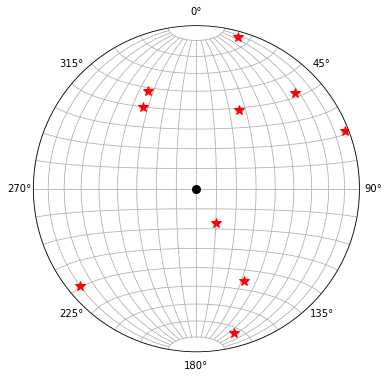

#1


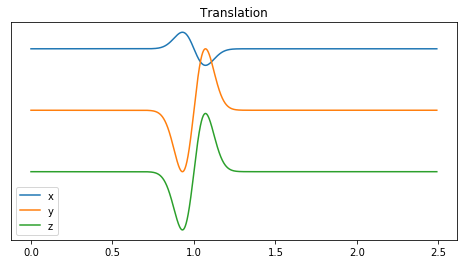

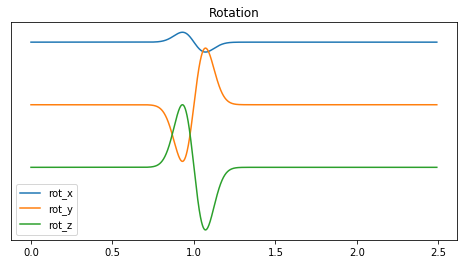

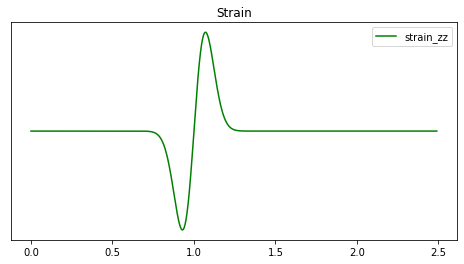

Estimated direction of propagation:
Theta: 49.824199405426604
Phi: 123.12000000000003
Actual direction of propagation:
Theta: 49.824199405426675
Phi: 123.12
Error (order of magnitude):
-14.897200904205222
---------------------------------- 
#2
Estimated direction of propagation:
Theta: 45.76765821590046
Phi: 61.91999999999994
Actual direction of propagation:
Theta: 45.76765821590043
Phi: 61.91999999999999
Error (order of magnitude):
-15.127983513303331
---------------------------------- 
#3
Estimated direction of propagation:
Theta: 87.11802229049196
Phi: 21.240000000000002
Actual direction of propagation:
Theta: 87.11802229049196
Phi: 21.24
Error (order of magnitude):
-15.954589770191003
---------------------------------- 
#4
Estimated direction of propagation:
Theta: 72.97742390666322
Phi: 44.28000000000002
Actual direction of propagation:
Theta: 72.97742390666325
Phi: 44.279999999999994
Error (order of magnitude):
-15.176438519807359
---------------------------------- 
#5
Estimated 

In [6]:
f = 10.
N = 10
wavetype = 'qP' #'qP','qS1','qS2'

nus, gammas = get_direction('random',C,N)
plot_directions(nus)
r2d = 180/np.pi
for i in range(0,len(nus)):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis_one_wavetype(wavetype,v,vel,nus[i],f)
    
    n,_,_ = get_polarizations(seis)
    
    it = np.argmax(seis[6,:])
    rx = seis[3,it]
    ry = seis[4,it]
    ezz = seis[6,it]
    
    nu_e = np.zeros(3) 
    nu_e[2] = 1.
    nu_e[1] = 2*rx/ezz + n[1]/n[2]
    nu_e[0] = -2*ry/ezz + n[0]/n[2]

    l = 0
    for j in range(0,3):
        l += nu_e[j]**2
    nu_e = nu_e / np.sqrt(l)
    
    print('#'+str(i+1))
    if i==0:
        plot_7C(seis,t)
    theta_e, phi_e = get_angles(nu_e)
    theta, phi = get_angles(nus[i])
    print('Estimated direction of propagation:')
    print('Theta: '+str(theta_e*r2d))
    print('Phi: '+str(phi_e*r2d))
    print('Actual direction of propagation:')
    print('Theta: '+str(theta*r2d))
    print('Phi: '+str(phi*r2d))
    print('Error (order of magnitude):')
    err = np.sqrt((nus[i][0]-nu_e[0])**2+(nus[i][1]-nu_e[1])**2+(nus[i][2]-nu_e[2])**2)
    print(np.log10(err))
    print('---------------------------------- ')
    